In [1]:
import pickle
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
episodes, rewards = [], []
path = './log/CTgraph-v0-ppo-scp/211024-163716/'
with open('{0}/config.json'.format(path), 'r') as f: 
    config = json.load(f)
num_tasks = config['cl_num_tasks']

# load data
for i in range(1, num_tasks+1):
    episodes.append([])
    rewards.append([])
    print('i=', i)
    #for j in range(1, i+1):
    for j in range(i, (num_tasks+1)):
        print('{0}/episodes-task{1}_{2}.bin'.format(path, j, i), ', j=', j)
        with open('{0}/episodes-task{1}_{2}.bin'.format(path, j, i), 'rb') as f: episodes[-1].append(pickle.load(f))
        with open('{0}/rewards-task{1}_{2}.bin'.format(path, j, i), 'rb') as f: rewards[-1].append(pickle.load(f))

i= 1
./log/CTgraph-v0-ppo-scp/211024-163716//episodes-task1_1.bin , j= 1
./log/CTgraph-v0-ppo-scp/211024-163716//episodes-task2_1.bin , j= 2
i= 2
./log/CTgraph-v0-ppo-scp/211024-163716//episodes-task2_2.bin , j= 2


In [3]:
# structure of rewards: num_tasks, num_task_evals, episode_idx
# structure of episodes: num_tasks, num_task_evals, episode_idx, ....(episode which is a dictionary)
num_episodes = len(episodes[0][0])
#pprint(episodes[0][0][0])

def process_data_vector(data, num_tasks, num_episodes, key):
    ret = [[] for _ in range(num_tasks)] # num_tasks, num_task_evals, num_episodes x episode_length
    for i in range(num_tasks):
        for j in range(num_tasks-i):
            values = []
            for k in range(num_episodes):
                values_ = episodes[i][j][k][key]
                values_ = [v.numpy().reshape(-1, ) for v in values_]
                values.append(values_)
            max_path_length = len(max(values, key=lambda v: len(v)))
            vec_dim = len(values[0][0])
            np_values = np.zeros((len(values), max_path_length, vec_dim), dtype=np.float32)
            for idx, v in enumerate(values):
                np_values[idx, 0 : len(v), : ] = v
            ret[i].append(np_values)
    return ret

def process_data_scalar(data, num_tasks, num_episodes, key):
    ret = [[] for _ in range(num_tasks)] # num_tasks, num_task_evals, num_episodes x episode_length
    for i in range(num_tasks):
        for j in range(num_tasks-i):
            values = []
            for k in range(num_episodes):
                values_ = episodes[i][j][k][key]
                values_ = [float(v) for v in values_]
                values.append(values_)
            max_path_length = len(max(values, key=lambda v: len(v)))
            np_values = np.zeros((len(values), max_path_length), dtype=np.float32)
            for idx, v in enumerate(values):
                np_values[idx, 0 : len(v)] = v
            ret[i].append(np_values)
    return ret

d = {}
d['value'] = process_data_scalar(episodes, num_tasks, num_episodes, 'value')
d['entropy'] = process_data_scalar(episodes, num_tasks, num_episodes, 'entropy')
d['logits'] = process_data_vector(episodes, num_tasks, num_episodes, 'logits')
d['sampled_action'] = process_data_scalar(episodes, num_tasks, num_episodes, 'sampled_action')
d['deterministic_action'] = process_data_scalar(episodes, num_tasks, num_episodes, 'deterministic_action')
d['log_prob'] = process_data_scalar(episodes, num_tasks, num_episodes, 'log_prob')
d['reward'] = process_data_scalar(episodes, num_tasks, num_episodes, 'reward')
d['terminal'] = process_data_scalar(episodes, num_tasks, num_episodes, 'terminal')
#print('task1', d['value'][0][0].shape)
#print('task2', d['value'][1][0].shape)
#print('task3', d['value'][2][0].shape)
#print('task4', d['value'][3][0].shape)

In [4]:
for i in range(num_tasks):
    print('task {0}'.format(i+1))
    for j in range(num_tasks - i):
        print('\tafter training on task {0}, eval: {1}'.format(j+1, d['reward'][i][j].sum(axis=1).mean()))
    #print('-'*30)

print()
for i in range(num_tasks):
    reward_ = 0
    for j in range(num_tasks - i):
        reward_ += d['reward'][i][j].sum(axis=1).mean()
    
    print('task {0} avg reward: {1}'.format(i+1, reward_/(num_tasks-i)))

task 1
	after training on task 1, eval: 1.0
	after training on task 2, eval: 1.0
task 2
	after training on task 1, eval: 0.0

task 1 avg reward: 1.0
task 2 avg reward: 0.0


### after training on task 1, 2, 3 and 4 respectively, average critic prediction (value function) on task 1

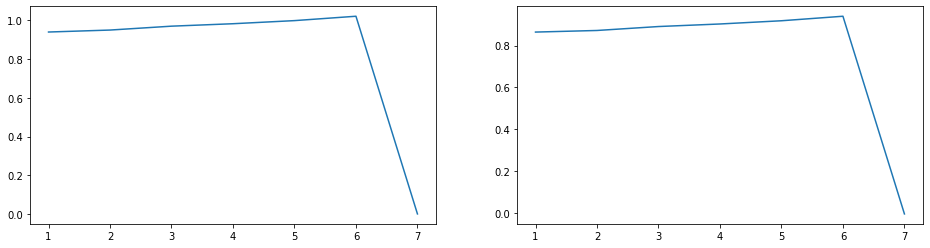

In [5]:
fig = plt.figure(figsize=(16, 4))
axs = fig.subplots(1, num_tasks)
for idx, ax in enumerate(axs):    
    avg = d['value'][0][idx].mean(axis=0)
    ax.plot(np.arange(1, len(avg)+1), avg)

### after training on task 2, 3 and 4 respectively, average critic prediction (value function) on task 2

TypeError: 'AxesSubplot' object is not iterable

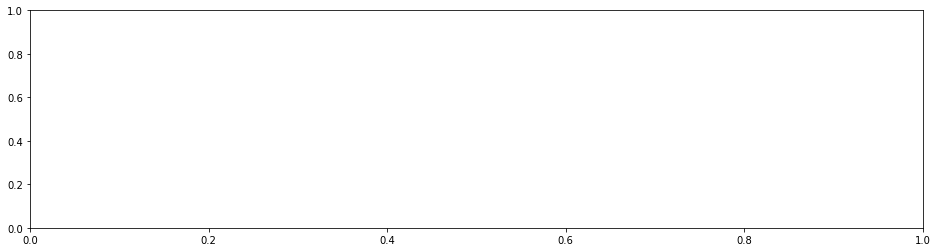

In [6]:
fig = plt.figure(figsize=(16, 4))
axs = fig.subplots(1, num_tasks-1)
for idx, ax in enumerate(axs):    
    avg = d['value'][1][idx].mean(axis=0)
    ax.plot(np.arange(1, len(avg)+1), avg)

### after training on task 3 and 4 respectively, average critic prediction (value function) on task 3

In [ ]:
fig = plt.figure(figsize=(16, 4))
axs = fig.subplots(1, num_tasks-2)
for idx, ax in enumerate(axs):    
    avg = d['value'][2][idx].mean(axis=0)
    ax.plot(np.arange(1, len(avg)+1), avg)

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots()
avg = d['value'][3][0].mean(axis=0)
ax.plot(np.arange(1, len(avg)+1), avg)

### TODO: plot td-error in addtion to critic prediction